In [27]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


In [37]:
import torch

class Autoencoder(torch.nn.Module):
  def __init__(self, input_dim, bottleneck_dim):
    super(Autoencoder, self).__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, bottleneck_dim),
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(bottleneck_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, input_dim),
    )

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed

In [38]:
from tqdm import tqdm

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
model = Autoencoder(784, 2).to("cuda")
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    bar = tqdm(dl)
    for digit, _ in bar:
        digit = digit.to("cuda")
        digit = digit.view(digit.shape[0], 28 * 28)
        
        recostructed = model(digit)

        loss = loss_fn(recostructed, digit)
        bar.set_description(f"Loss: {loss.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Loss: 0.3787: 100%|██████████| 1875/1875 [00:08<00:00, 219.35it/s]


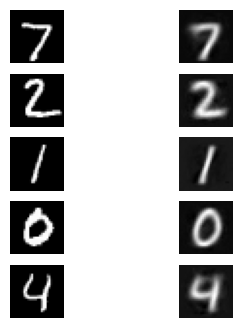

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 2, figsize=(4, 4))

for i in range(5):
    digit = test_mnist[i][0].view(1, 28 * 28).to("cuda")
    recostructed = model(digit).cpu().detach().numpy().reshape(28, 28)

    axes[i][0].imshow(test_mnist[i][0].reshape(28, 28), cmap="gray")
    axes[i][1].imshow(recostructed, cmap="gray")

    axes[i][0].axis("off")
    axes[i][1].axis("off")



plt.show()

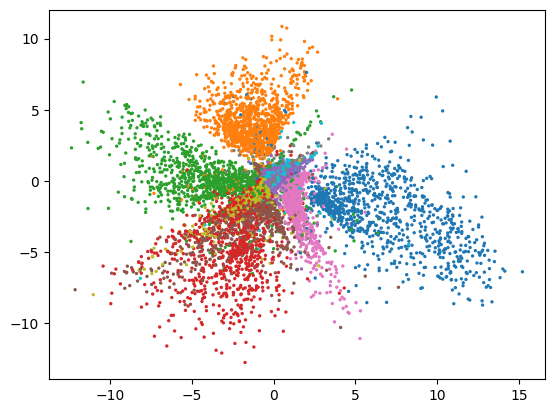

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
dl = torch.utils.data.DataLoader(test_mnist, batch_size=32)

for digit, cls in dl:
    digit = digit.view(-1, 28 * 28).to("cuda")
    latent = model.encoder(digit).cpu().detach().numpy()

    ax.scatter(latent[:, 0], latent[:, 1], c=cls, cmap="tab10", s=2)

plt.show()

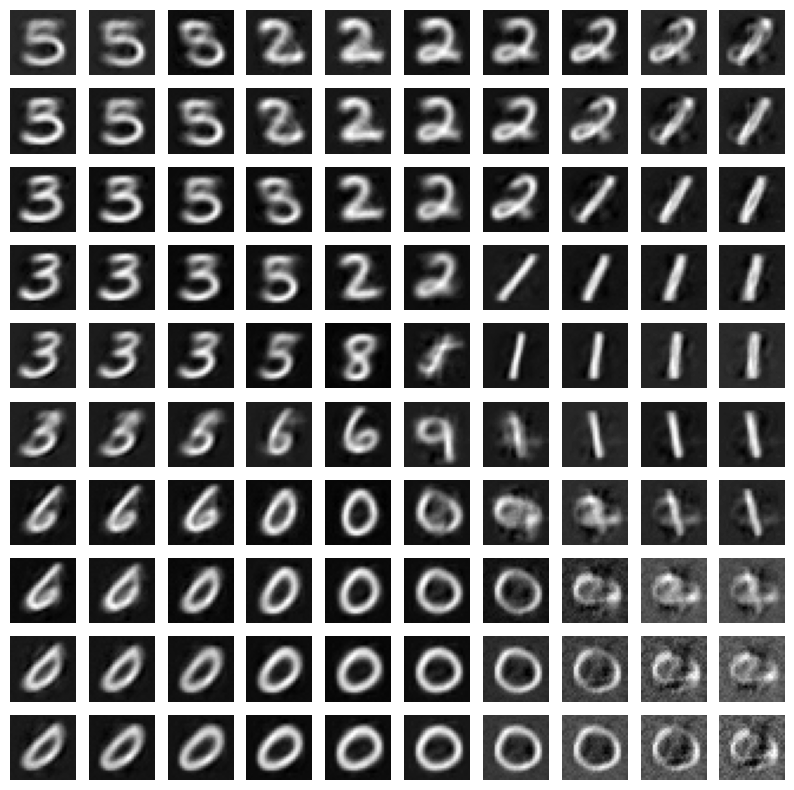

In [45]:
xx = torch.linspace(-10, 10, 10)
yy = torch.linspace(-10, 10, 10)

fig, ax = plt.subplots(10, 10, figsize=(10, 10))

for i, x in enumerate(xx):
    for j, y in enumerate(yy):
        latent = torch.tensor([[x, y]]).to("cuda")
        recostructed = model.decoder(latent).cpu().detach().numpy().reshape(28, 28)

        ax[i][j].imshow(recostructed, cmap="gray")
        ax[i][j].axis("off")